In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, make_scorer, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.dummy import DummyClassifier
from time import time
from sklearn.model_selection._search import ParameterGrid
from scipy.stats import loguniform, randint


import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
CSV_PATH = Path("../data/bank-additional-full.csv")

In [2]:
# ------------------------------------------------------------
# 1) Carregar dataset
# ------------------------------------------------------------
df = pd.read_csv(CSV_PATH, sep=";")

print("Arquivo carregado:", CSV_PATH.resolve())
print("Shape:", df.shape)
display(df.head())

# ------------------------------------------------------------
# 2) Definir alvo (target)
# ------------------------------------------------------------
# No dataset, a variável alvo costuma ser "y" com valores {yes, no}.
TARGET_COL = "y"
if TARGET_COL not in df.columns:
    raise ValueError("A coluna alvo 'y' não foi encontrada no CSV. Verifique o arquivo carregado.")

print("\nDistribuição do alvo (bruto):")
print(df[TARGET_COL].value_counts(dropna=False))


# ------------------------------------------------------------
# 3) Checar missing values e tipos de dados
# ------------------------------------------------------------
# - numéricos -> imputação mediana + escala (z-score)
# - categóricos -> imputação moda + one-hot
missing = df.isna().mean().sort_values(ascending=False)
print("\nTop colunas com missing (%):")
display(missing.head(15))

print("\nDtypes (amostra):")
display(df.dtypes.head(25))

Arquivo carregado: /workspaces/Ciencia_Dados_UFC/Atividade_3/data/bank-additional-full.csv
Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



Distribuição do alvo (bruto):
y
no     36548
yes     4640
Name: count, dtype: int64

Top colunas com missing (%):


age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
duration       0.0
campaign       0.0
pdays          0.0
previous       0.0
poutcome       0.0
dtype: float64


Dtypes (amostra):


age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [3]:
# ------------------------------------------------------------
# 4) Split treino/teste (estratificado)
# ------------------------------------------------------------
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].map({"no": 0, "yes": 1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("\nTrain:", X_train.shape, "Test:", X_test.shape)
print("\nDistribuição y (train):")
print(y_train.value_counts(normalize=True))
print("\nDistribuição y (test):")
print(y_test.value_counts(normalize=True))


Train: (32950, 20) Test: (8238, 20)

Distribuição y (train):
y
0    0.887344
1    0.112656
Name: proportion, dtype: float64

Distribuição y (test):
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


In [4]:
# ------------------------------------------------------------
# 5) Pré-processamento com Pipeline + ColumnTransformer
# ------------------------------------------------------------
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


=== Baseline (most_frequent) ===
Accuracy : 0.8873512988589464
Precision: 0.0
Recall   : 0.0
F1       : 0.0


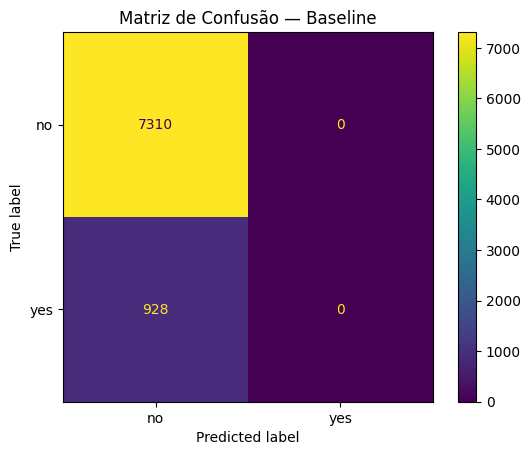

In [5]:
# ------------------------------------------------------------
# 6) Baseline (DummyClassifier)
# ------------------------------------------------------------
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
])

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print("\n=== Baseline (most_frequent) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_base, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_base, zero_division=0))

cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(cm, display_labels=["no", "yes"])
disp.plot(values_format="d")
plt.title("Matriz de Confusão — Baseline")
plt.show()


In [6]:
# ------------------------------------------------------------
# 7) Modelos a comparar
# ------------------------------------------------------------
# - LogReg (linear): rápido e bom baseline
# - KNN (distância): depende de escala
# - DecisionTree / RandomForest: árvore(s), robustos e interpretáveis
# - HistGB: boosting
# - SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

pipelines = {
    "LogReg": Pipeline(steps=[("preprocess", preprocess), 
                              ("model", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))]),
    
    "KNN": Pipeline(steps=[("preprocess", preprocess), 
                           ("model", KNeighborsClassifier())]),
    
    "DecisionTree": Pipeline(steps=[("preprocess", preprocess), 
                                    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    
    "RandomForest": Pipeline(steps=[("preprocess", preprocess), 
                                    ("model", RandomForestClassifier(random_state=RANDOM_STATE))]),
    
    "HistGB": Pipeline(steps=[("preprocess", preprocess), 
                              ("model", HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
    
    # SVC é pesado. Se demorar muito, use apenas os 5 acima.
    "SVC": Pipeline(steps=[("preprocess", preprocess), 
                           ("model", SVC(random_state=RANDOM_STATE))])
}

In [ ]:


# ------------------------------------------------------------
# 8) Validação cruzada estratificada + métricas
# ------------------------------------------------------------
# StratifiedKFold: preserva proporção de classes em cada fold 
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
}

# ------------------------------------------------------------
# 9) Espaço de busca
# ------------------------------------------------------------

# - GridSearch com muitos hiperparâmetros pode explodir combinações
# - RandomizedSearch escolhe amostras do espaço (mais eficiente)
#
# class_weight="balanced" aparece em vários modelos:
# - ajuda a compensar desbalanceamento
#
# RandomForest:
# - n_jobs=-1 paraleliza árvores internamente (mais rápido).

if "RandomForest" in pipelines:
    pipelines["RandomForest"].set_params(model__n_jobs=-1)

param_dists = {
    "LogReg": {
        "model__C": loguniform(1e-2, 1e2),
        "model__class_weight": [None, "balanced"],
    },

    "SVC": {
        "model__C": loguniform(1e-1, 1e1),
        "model__gamma": loguniform(1e-3, 1e-1),
        "model__class_weight": [None, "balanced"],
        "model__kernel": ["rbf"],
    },

    "KNN": {
        "model__n_neighbors": randint(3, 120),
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },

    "DecisionTree": {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_leaf": randint(1, 30),
        "model__min_samples_split": randint(2, 60),
        "model__class_weight": [None, "balanced"],
    },

    "RandomForest": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": randint(1, 20),
        "model__min_samples_split": randint(2, 40),
        "model__class_weight": [None, "balanced"],
        "model__max_features": ["sqrt", 0.5],
    },

    "HistGB": {
        "model__learning_rate": loguniform(1e-2, 2e-1),
        "model__max_depth": [None, 5, 10],
        "model__max_leaf_nodes": [31, 63],
        "model__min_samples_leaf": [20, 50],
        "model__max_iter": [200, 400, 800],
        "model__early_stopping": [True],
        "model__validation_fraction": [0.1],
        "model__n_iter_no_change": [10],
    },
}

param_dists = {k: v for k, v in param_dists.items() if k in pipelines}

def param_space_size(param_dist: dict):
    """Se houver distribuições contínuas, retorna None (infinito). Se for finito, retorna o total."""
    for v in param_dist.values():
        if hasattr(v, "rvs"):
            return None
    return len(list(ParameterGrid(param_dist)))


# ------------------------------------------------------------
# 10) RandomizedSearch por modelo + avaliação no teste
# ------------------------------------------------------------
# refit="f1": escolhe o melhor modelo por F1
results = []
best_estimators = {}

DEFAULT_N_ITER = 15

for name, pipe in pipelines.items():
    if name not in param_dists:
        print(f"Pulando {name} (sem param_dists definido).")
        continue

    print(f"\n=== RandomizedSearch: {name} ===")

    size = param_space_size(param_dists[name])
    n_iter = DEFAULT_N_ITER if size is None else min(DEFAULT_N_ITER, size)

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dists[name],
        n_iter=n_iter,
        scoring=scoring,
        refit="f1",   
        cv=cv_fast,
        n_jobs=1,     
        verbose=1,
        random_state=RANDOM_STATE,
        return_train_score=False,
        error_score="raise"
    )

    t0 = time()
    search.fit(X_train, y_train)
    elapsed = time() - t0

    print("n_iter usado:", n_iter)
    print("Melhor F1 (CV):", search.best_score_)
    print("Melhores hiperparâmetros:", search.best_params_)
    print(f"Tempo: {elapsed:.1f}s")

    best_estimators[name] = search.best_estimator_

    y_pred = search.best_estimator_.predict(X_test)

    results.append({
        "model": name,
        "cv_f1": search.best_score_,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_precision": precision_score(y_test, y_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_pred, zero_division=0),
        "test_f1": f1_score(y_test, y_pred, zero_division=0),
        "best_params": search.best_params_
    })

results_df = pd.DataFrame(results).sort_values(by="test_f1", ascending=False)

display(results_df[["model", "cv_f1", "test_f1", "test_precision", "test_recall", "test_accuracy"]])
display(results_df)



=== RandomizedSearch: LogReg ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits


n_iter usado: 15
Melhor F1 (CV): 0.5839365553814465
Melhores hiperparâmetros: {'model__C': np.float64(0.21618942406574443), 'model__class_weight': 'balanced'}
Tempo: 25.2s

=== RandomizedSearch: KNN ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
n_iter usado: 15
Melhor F1 (CV): 0.4832315700640432
Melhores hiperparâmetros: {'model__n_neighbors': 5, 'model__p': 2, 'model__weights': 'uniform'}
Tempo: 258.8s

=== RandomizedSearch: DecisionTree ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
n_iter usado: 15
Melhor F1 (CV): 0.5820034210972178
Melhores hiperparâmetros: {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__min_samples_leaf': 28, 'model__min_samples_split': 17}
Tempo: 10.1s

=== RandomizedSearch: RandomForest ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
n_iter usado: 15
Melhor F1 (CV): 0.6378710513465501
Melhores hiperparâmetros: {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features

In [ ]:
# ------------------------------------------------------------
# 11) Selecionar modelo mais promissor (critério: maior F1 no teste)
# ------------------------------------------------------------
best_model_name = results_df.iloc[0]["model"]
best_model = best_estimators[best_model_name]
best_params = results_df.iloc[0]["best_params"]

print("\nModelo mais promissor:", best_model_name)
print("Hiperparâmetros escolhidos:", best_params)


# ------------------------------------------------------------
# 12) Avaliação final do vencedor + matriz de confusão
# ------------------------------------------------------------
y_pred_best = best_model.predict(X_test)

print("\n=== Resultados finais (hold-out) ===")
print("Modelo   :", best_model_name)
print("Accuracy :", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_best, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_best, zero_division=0))

print("\nClassification report:")
print(classification_report(y_test, y_pred_best, target_names=["no", "yes"], zero_division=0))

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(cm, display_labels=["no", "yes"])
disp.plot(values_format="d")
plt.title(f"Matriz de Confusão — Melhor Modelo ({best_model_name})")
plt.show()